# Ring broadcast experiment

In this experiment, N ranks perform a ring broadcast. We measure the duration of the individual calls to `MPI_Recv` and `MPI_Send`. The main part of the code is basically like this (for a given broadcast):

```c
for(int rank=0; rank<nb_ranks; rank++) {
    int sender = rank;
    int receiver = (rank+1)%nb_ranks;
    if(my_rank == sender) {
        start_time=get_time();
        MPI_Send(my_send_buffer, size, MPI_CHAR, receiver, 0, MPI_COMM_WORLD);
        total_time=get_time()-start_time;
        print_in_file(file, "MPI_Send", my_rank, size, start_time-base_time, total_time);
    }
    else if(my_rank == receiver) {
        int flag = 0;
        while(!flag) {
            MPI_Iprobe(sender, 0, MPI_COMM_WORLD, &flag, MPI_STATUS_IGNORE);
        }
        start_time=get_time();
        MPI_Recv(my_recv_buffer, size, MPI_CHAR, sender, 0, MPI_COMM_WORLD, MPI_STATUS_IGNORE);
        total_time=get_time()-start_time;
        print_in_file(file, "MPI_Recv", my_rank, size, start_time-base_time, total_time);
    }
}
```

In [1]:
import io
import os
import zipfile
import pandas
import yaml
from plotnine import *
import plotnine
import sys
plotnine.options.figure_size = (12, 8)
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # removing annoying Pandas warning

def read_csv(archive_name, csv_name, columns=None, filter_func=lambda x: x, usecols=None):
    archive = zipfile.ZipFile(archive_name)
    df= pandas.read_csv(io.BytesIO(filter_func(archive.read(csv_name))), names=columns)
    df.columns = df.columns.str.strip()
    return df

def get_yaml(archive_name, yaml_name):
    archive = zipfile.ZipFile(archive_name)
    return yaml.load(io.BytesIO(archive.read(yaml_name)))

In [2]:
archive = 'ring/1/grenoble_2020-08-17_1944647.zip'
df = read_csv(archive, 'result.csv')
print(len(df))
df.head()

368640


,function,rank,size,timestamp,duration
0,MPI_Send,0,8584,0.000003,0.000013
1,MPI_Recv,0,8584,0.002870,0.000005
2,MPI_Send,0,8584,0.002876,0.000003
3,MPI_Recv,0,8584,0.003354,0.000001
4,MPI_Send,0,8584,0.003356,0.000005


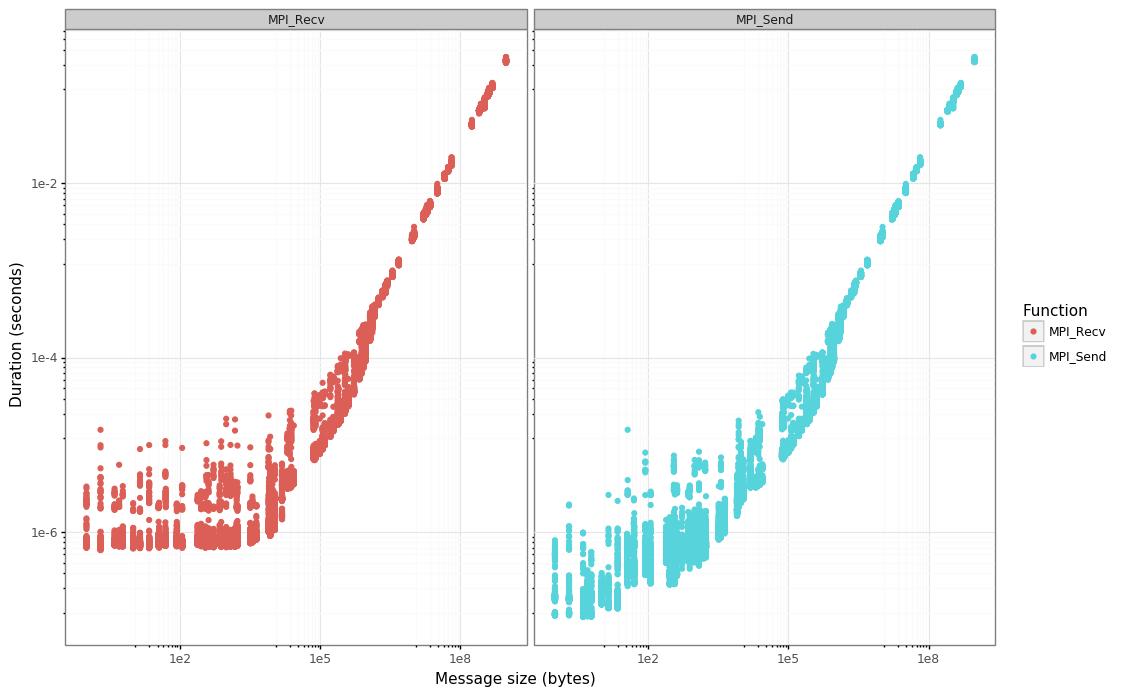

<ggplot: (-9223363299596236551)>

In [3]:
(ggplot(df[(df['rank'] > 0) & (df['rank'] < 10)])
    + aes(x='size', y='duration', color='function')
    + geom_point() 
    + theme_bw()
    + scale_x_log10()
    + scale_y_log10()
    + facet_wrap('function')
    + labs(x='Message size (bytes)', y='Duration (seconds)', color='Function')
)

In [4]:
df['rank+1'] = df['rank'] + 1
df['start'] = df['timestamp']
df['end'] = df['start'] + df['duration']

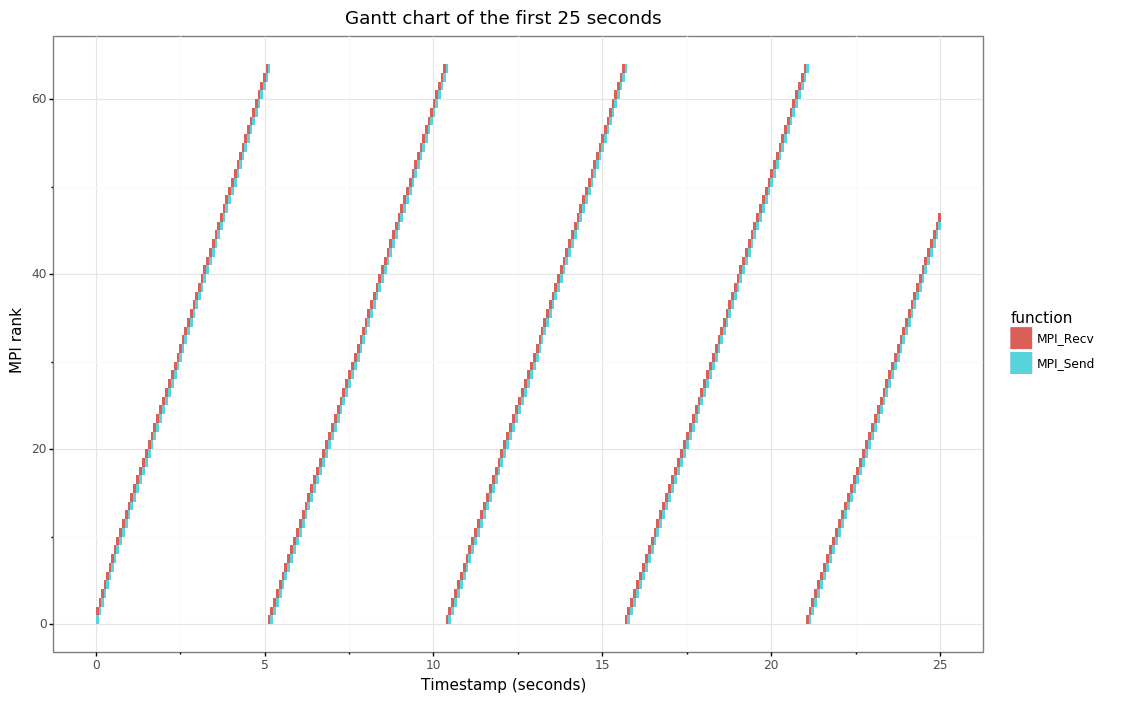

<ggplot: (8737352286805)>

In [5]:
def plot(df):
    return (ggplot(df)
        + geom_rect(aes(xmin='start', xmax='end', ymin='rank', ymax='rank+1',fill='function'))
        + theme_bw()
        + labs(x='Timestamp (seconds)', y='MPI rank', color='Function')
    )

plot(df[df['start'] < 25]) + ggtitle('Gantt chart of the first 25 seconds')

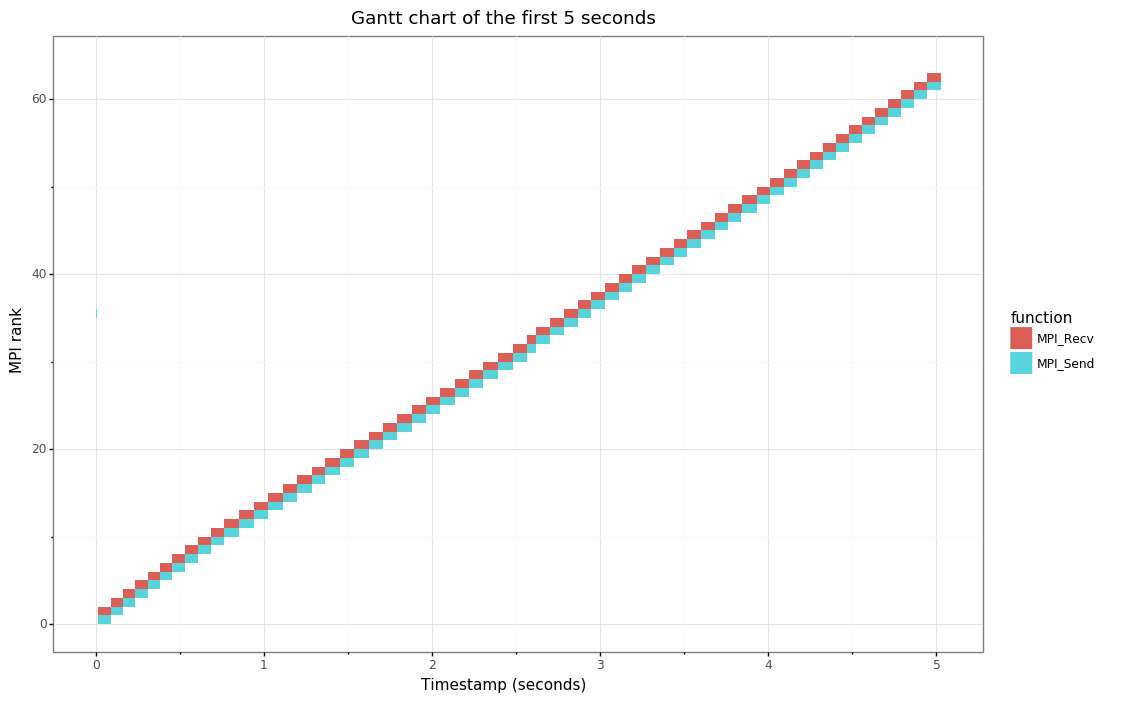

<ggplot: (8737251776776)>

In [6]:
plot(df[df['start'] < 5]) + ggtitle('Gantt chart of the first 5 seconds')

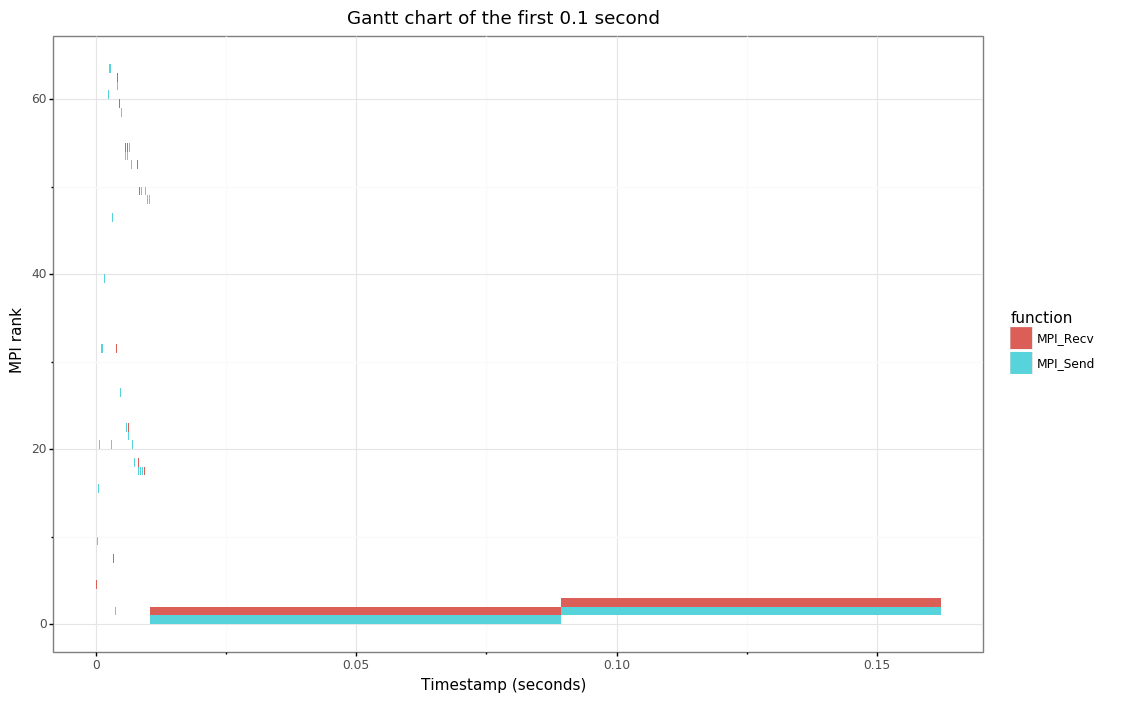

<ggplot: (-9223363299609829877)>

In [7]:
plot(df[df['start'] < 0.1]) + ggtitle('Gantt chart of the first 0.1 second')

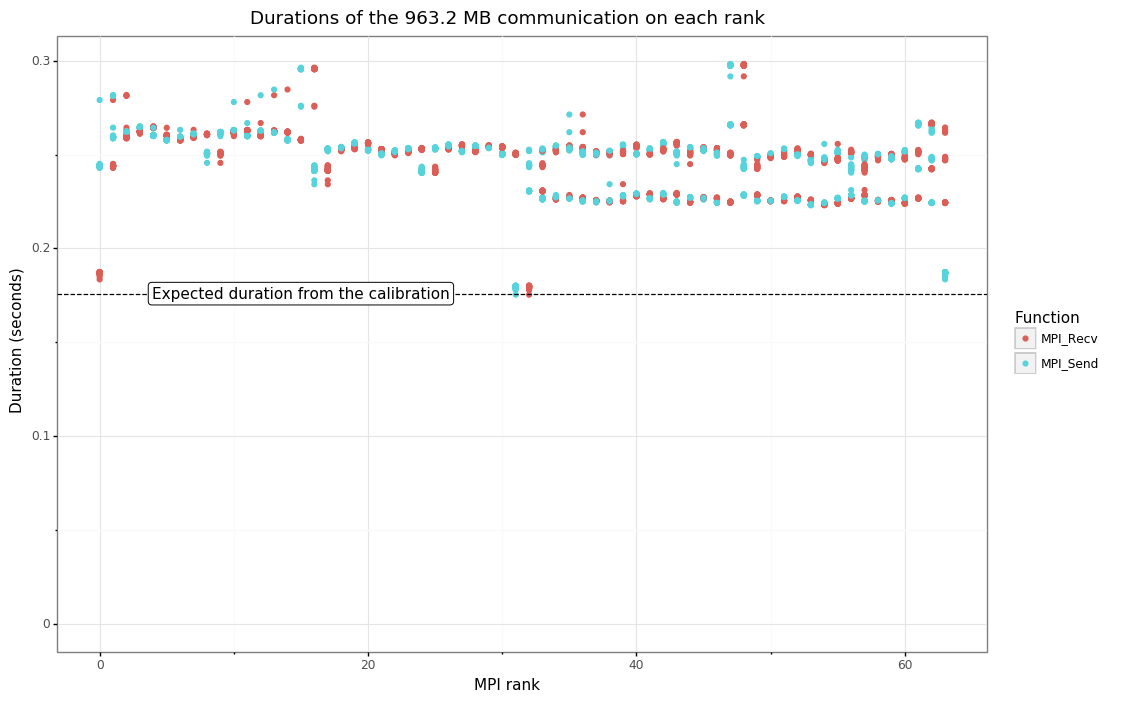

<ggplot: (-9223363299603265241)>

In [8]:
bw  = 25*1e9
lat = 0.1*1e-6
bw_factor = 0.219
lat_factor = 0
size = df['size'].max()
theoretical_duration = size/(bw*bw_factor) + lat*lat_factor

(ggplot(df[df['size'] == size])
    + aes(x='rank', y='duration', color='function')
    + geom_point() 
    + theme_bw()
    + expand_limits(y=0)
    + geom_hline(yintercept=theoretical_duration, linetype='dashed')
    + labs(x='MPI rank', y='Duration (seconds)', color='Function')
    + annotate('label', x=15, y=theoretical_duration, label='Expected duration from the calibration')
    + ggtitle(f'Durations of the {size*1e-6:.1f} MB communication on each rank')
)

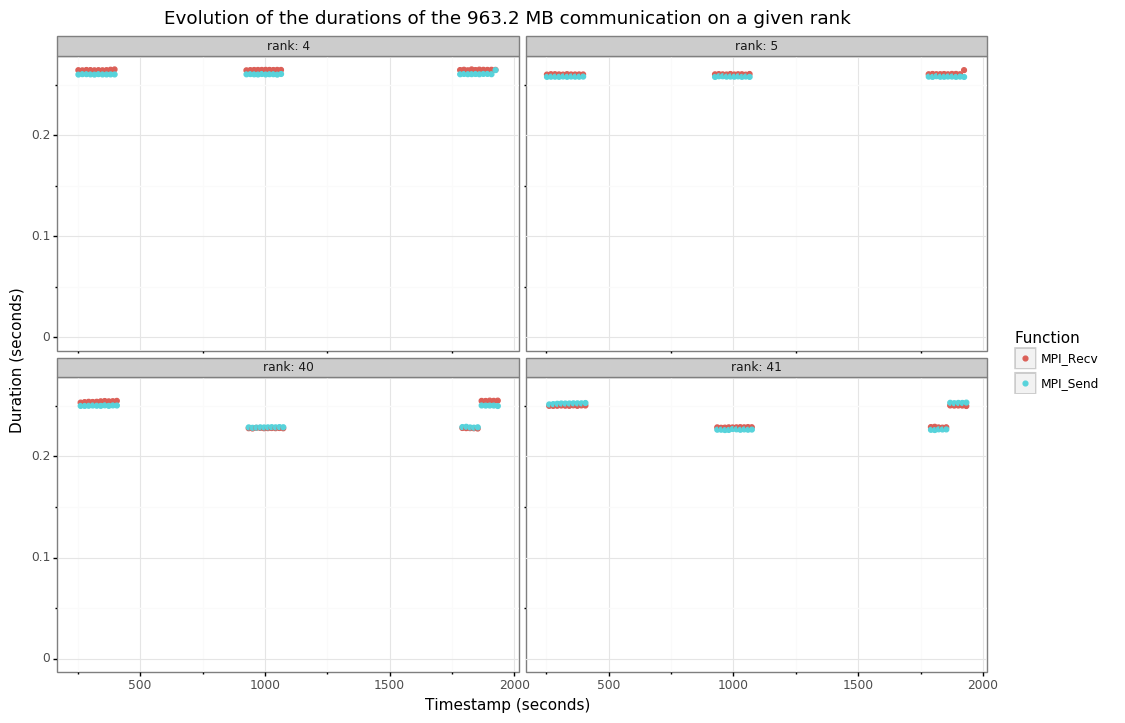

<ggplot: (8737244758476)>

In [9]:
(ggplot(df[(df['size'] == size) & (df['rank'].isin({4,5,40,41}))])
    + aes(x='timestamp', y='duration', color='function')
    + geom_point()
    + theme_bw()
    + expand_limits(y=0)
    + facet_wrap('rank', labeller='label_both')
    + labs(x='Timestamp (seconds)', y='Duration (seconds)', color='Function')
    + ggtitle(f'Evolution of the durations of the {size*1e-6:.1f} MB communication on a given rank')
)

## Monitoring

In [10]:
import cashew
print(cashew.__git_version__)
from cashew import archive_extraction

c0a430e3a498fc690b6244ca9909444040c28128


In [11]:
monitoring = archive_extraction.read_monitoring(archive)
monitoring['date'] = pandas.to_datetime(monitoring['start_time'], unit='s').astype(str)
for date in monitoring['date'].unique():
    monitoring.loc[monitoring['date'] == date, 'real_start_time'] = monitoring[monitoring['date'] == date]['timestamp'].min()
monitoring['start_exp'] -= monitoring['real_start_time']
monitoring['stop_exp'] -= monitoring['real_start_time']
monitoring['timestamp'] -= monitoring['real_start_time']
monitoring['cpu_id'] = monitoring['node'].astype(str) + ':' + monitoring['cpu'].astype(str)
monitoring['in_exp'] = (monitoring['timestamp'] > monitoring['start_exp'] + 60) & (monitoring['timestamp'] < monitoring['stop_exp'] - 60)
monitoring['hostname'] = monitoring['cluster'] + '-' + monitoring['node'].astype(str)
print(len(monitoring))
monitoring.head()

396576


,timestamp,cluster,node,jobid,start_time,expfile_hash,value,cpu,core,kind,start_exp,stop_exp,date,real_start_time,cpu_id,in_exp,hostname
0,0.002834,dahu,3,1944647,1597678480,199480a2b88da84036d4eb9076b659fec9b511c0f6ebb4...,1.000012,0,0,frequency,16.734773,2088.101039,2020-08-17 15:34:40,1.597686e+09,3:0,False,dahu-3
1,1.010950,dahu,3,1944647,1597678480,199480a2b88da84036d4eb9076b659fec9b511c0f6ebb4...,2.915313,0,0,frequency,16.734773,2088.101039,2020-08-17 15:34:40,1.597686e+09,3:0,False,dahu-3
2,2.019280,dahu,3,1944647,1597678480,199480a2b88da84036d4eb9076b659fec9b511c0f6ebb4...,1.908380,0,0,frequency,16.734773,2088.101039,2020-08-17 15:34:40,1.597686e+09,3:0,False,dahu-3
3,3.028141,dahu,3,1944647,1597678480,199480a2b88da84036d4eb9076b659fec9b511c0f6ebb4...,1.378765,0,0,frequency,16.734773,2088.101039,2020-08-17 15:34:40,1.597686e+09,3:0,False,dahu-3
4,4.035896,dahu,3,1944647,1597678480,199480a2b88da84036d4eb9076b659fec9b511c0f6ebb4...,1.092297,0,0,frequency,16.734773,2088.101039,2020-08-17 15:34:40,1.597686e+09,3:0,False,dahu-3


In [12]:
grouped_mon = monitoring[monitoring.in_exp].groupby(['node', 'cpu', 'cpu_id', 'kind'])[['value']].mean().reset_index()
grouped_mon.head()

,node,cpu,cpu_id,kind,value
0,3,0,3:0,frequency,2.638738
1,3,0,3:0,temperature,77.744881
2,3,1,3:1,frequency,2.760340
3,3,1,3:1,temperature,66.862720
4,9,0,9:0,frequency,2.708164


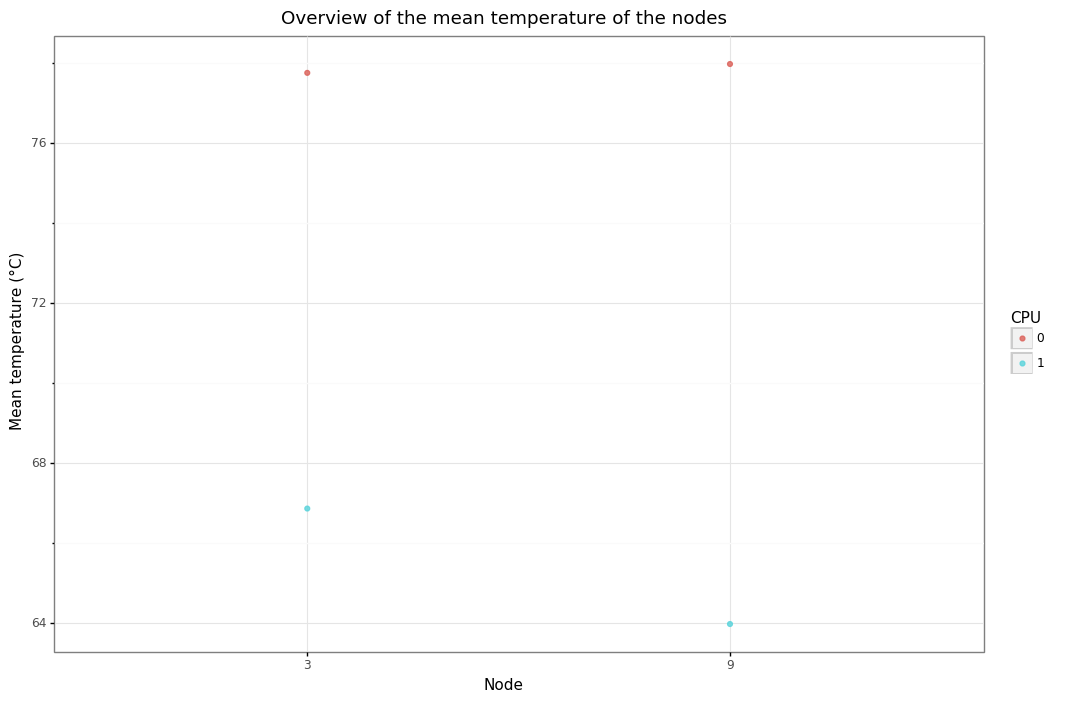

<ggplot: (8737242993647)>

In [13]:
(ggplot(grouped_mon[grouped_mon['kind'] == 'temperature'])
    + aes(x='factor(node)', y='value', color='factor(cpu)')
    + geom_point(alpha=0.8)
    + theme_bw()
    + labs(x='Node', y='Mean temperature (°C)', color='CPU')
    + ggtitle('Overview of the mean temperature of the nodes')
)

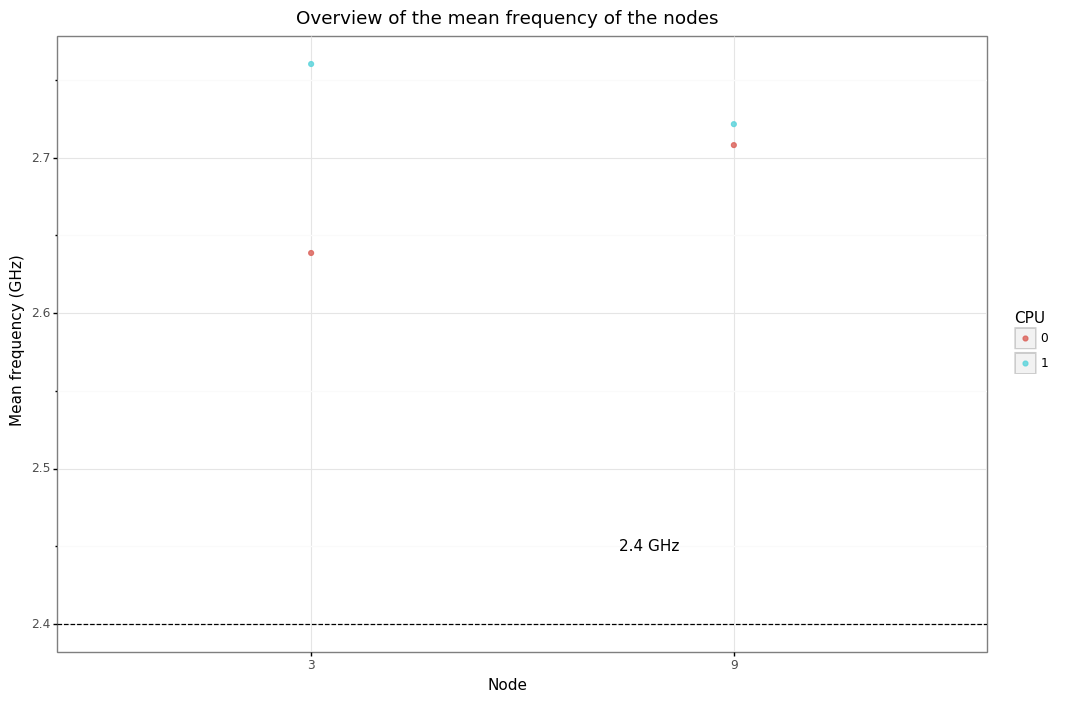

<ggplot: (8737251669035)>

In [14]:
(ggplot(grouped_mon[grouped_mon['kind'] == 'frequency'])
    + aes(x='factor(node)', y='value', color='factor(cpu)')
    + geom_point(alpha=0.8)
    + theme_bw()
    + labs(x='Node', y='Mean frequency (GHz)', color='CPU')
    + ggtitle('Overview of the mean frequency of the nodes')
    + geom_hline(yintercept=2.4, linetype='dashed')
    + annotate('text', label='2.4 GHz', x=1.8, y=2.45)
)

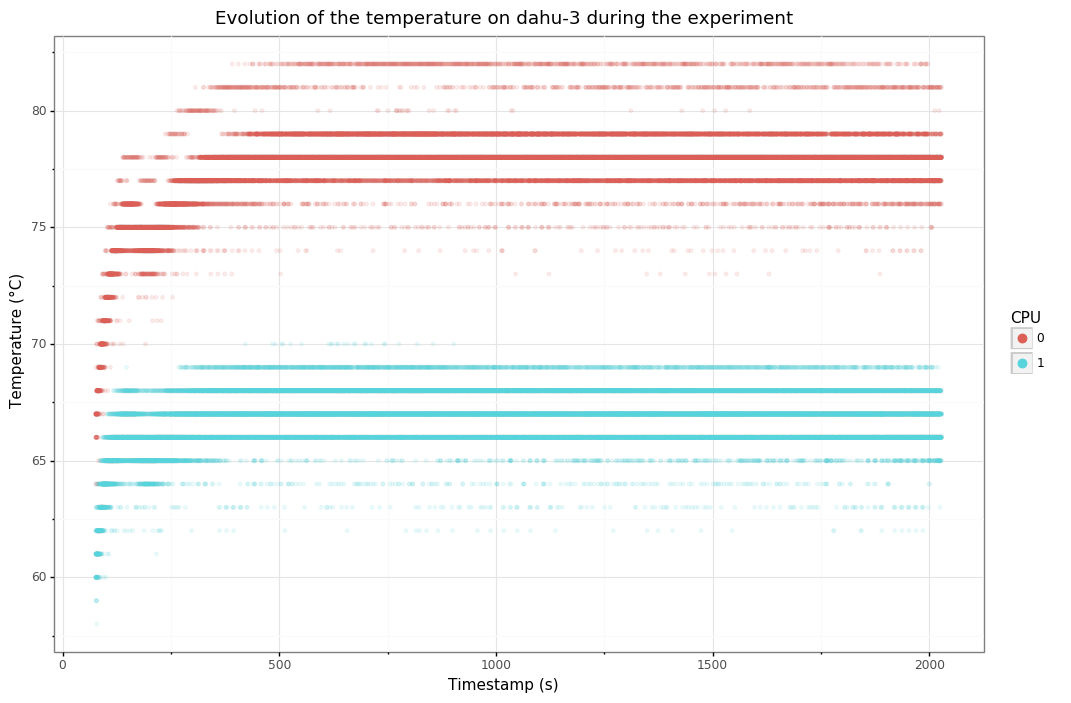

<ggplot: (-9223363299603601583)>


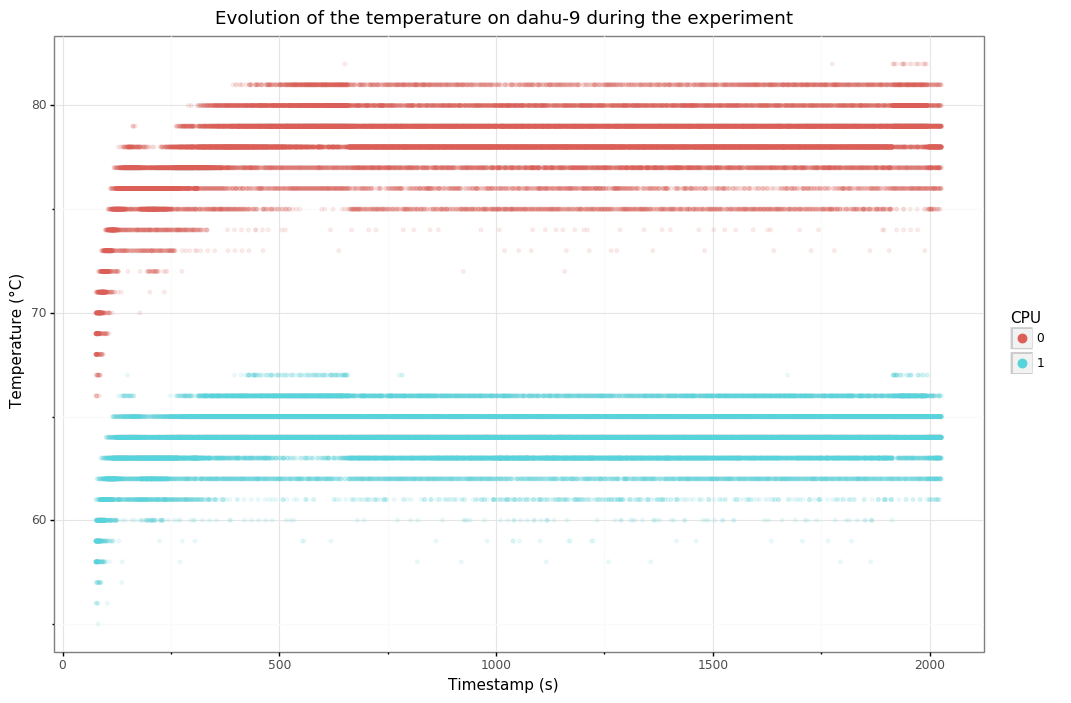

<ggplot: (8737254054860)>


In [15]:
for node in sorted(monitoring.node.unique()):
    print(ggplot(monitoring[(monitoring.in_exp) & (monitoring.node == node) & (monitoring.kind == 'temperature')])
        + aes(x='timestamp', y='value', color='factor(cpu)')
        + geom_point(alpha=0.1, size=1)
        + theme_bw()
        + labs(x='Timestamp (s)', y='Temperature (°C)', color='CPU')
        + ggtitle(f'Evolution of the temperature on dahu-{node} during the experiment')
        + guides(colour = guide_legend(override_aes = {'alpha': 1, 'size': 3}))
    )

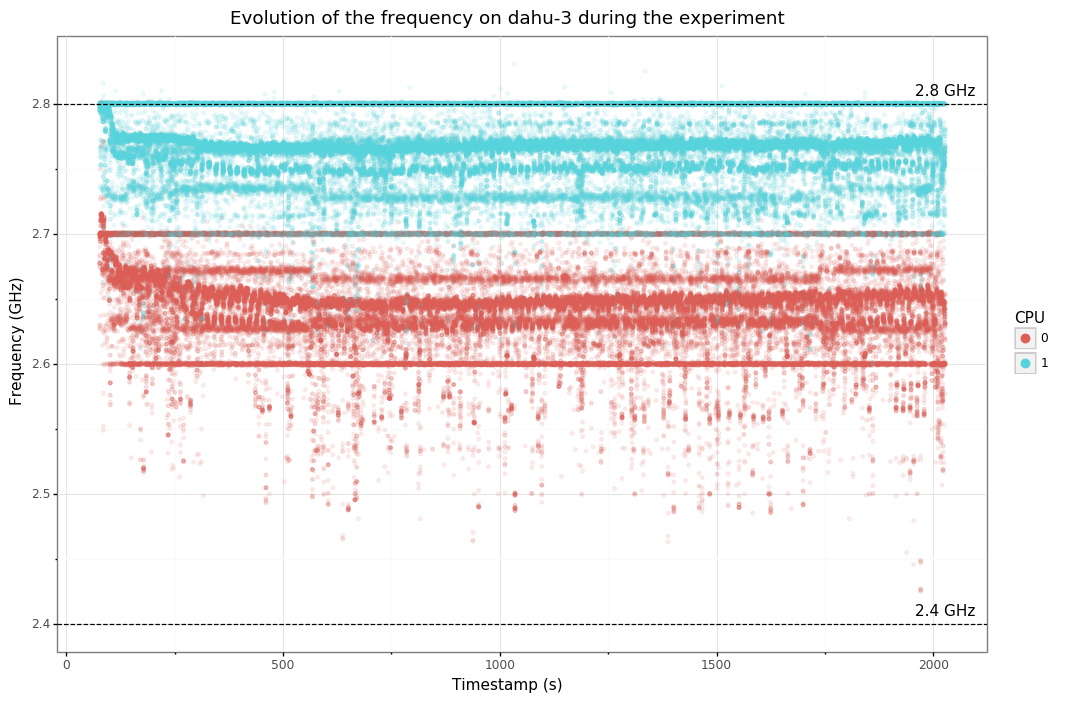

<ggplot: (8737251708750)>


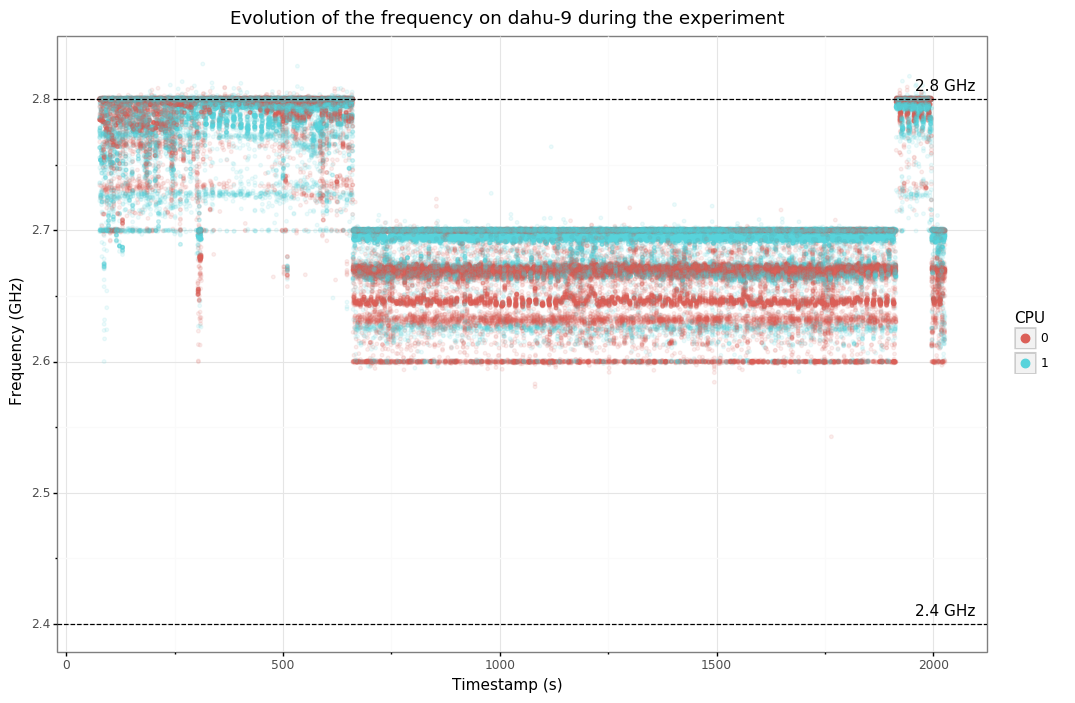

<ggplot: (8737254030470)>


In [16]:
for node in sorted(monitoring.node.unique()):
    print(ggplot(monitoring[(monitoring.in_exp) & (monitoring.node == node) & (monitoring.kind == 'frequency')])
        + aes(x='timestamp', y='value', color='factor(cpu)')
        + geom_point(alpha=0.1, size=1)
        + theme_bw()
        + labs(x='Timestamp (s)', y='Frequency (GHz)', color='CPU')
        + ggtitle(f'Evolution of the frequency on dahu-{node} during the experiment')
        + guides(colour = guide_legend(override_aes = {'alpha': 1, 'size': 3}))
        + geom_hline(yintercept=2.4, linetype='dashed')
        + annotate('text', label='2.4 GHz', x=monitoring[monitoring.in_exp].timestamp.max(), y=2.41)
        + geom_hline(yintercept=2.8, linetype='dashed')
        + annotate('text', label='2.8 GHz', x=monitoring[monitoring.in_exp].timestamp.max(), y=2.81)
    )